# Anya's Prospector Tutorial 

Date created: Oct 29, 2024.

I've set up this tutorial to first break down the parameter file, then show how we analyze the results after we run the code.

## Getting Everything Installed Correctly
If you have access to /n/home01/anugent/.conda/envs/prospector_env directory on Cannon then simply do: conda activate /n/home01/anugent/.conda/envs/prospector_env (or just ask me to make a copy of the environment and send it to you).

If you do not have access to this, or want to create your own Prospector environment follow these instructions:

1. Create a conda environment with Python 3.10 (note that Prospector has frequent updates, so if you are installing ~1 year after this notebook was created, please check to see if there is a new version of Prospector: https://prospect.readthedocs.io/en/latest/installation.html.)
2. Install numpy (v1.26.4), scipy (v1.11.2), matplotlib (v3.8.4), corner (v2.2.2), h5py (v3.11.0), astropy (v5.3.2), dynesty (v2.1.4), astro-sedpy (v0.3.2), and astro-prospector (v1.4.0).
3. Get FSPS (note: this is the fortran version, not python!)
    
    a. Use this command: git clone https://github.com/cconroy20/fsps
    
    b. Then, we need to edit the "Makefile" in the src directory (cd src; vi Makefile)
    
    c. Within the Makefile: make sure the F90 = gfortran line is uncommented.
    
    d. Within the Makefile: comment the F90FLAGS = -O -cpp line and uncomment F90FLAGS = -O3 -march=native -cpp
    
    e. Add -fPIC to the line you just uncommented so that it reads: F90FLAGS = -O3 -march=native -cpp -fPIC
    
    f. Save the Makefile then use these commands: make clean; make all

4. Now we need python-fsps!
    
    a. Use this command (might be useful to have this in your .bashrc or activated with your environment): export SPS_HOME=$HOME/fsps - note: $HOME is wherever the fsps directory is. So when I run Prospector on Cannon, the line is: export SPS_HOME=/n/home01/anugent/.conda/envs/prospector_env/lib/python3.12/site-packages/fsps
    
    b. Now, you can pip install fsps or grab python-fsps's git to install

5. It should work now, but try using running all the commands in this jupyter notebook and running the lines:
        python param_file.py
        
   
   (NOTE: you will have to have parameter file for this to work -- so create one/grab the example I have: param_file.py)

    


## Breaking Down the Parameter File

There are several key functions within the parameter file that we can change depending on our scientific interests: 
1. <font color=green>run_params</font> dictionary 
2. <font color=green>build_obs( )</font> function - or, photometry and spectroscopy of galaxy 
3. <font color=green>build_model( )</font> function - where we build the model for the galaxy 

Let's start with all the packages we need to load into the parameter file:
- You won't need matplotlib, I just added it in so we could visualize what Prospector does.
- Basically everything should be in numpy arrays, which is why we need numpy.
- We need to load in all the functions the build the model.
- SedPy is great for using the filter transmission curves. 

In [1]:
%matplotlib inline
import sys, os
import numpy as np
from sedpy.observate import load_filters
from prospect import prospect_args
from prospect.fitting import fit_model, lnprobfn
from prospect.io import write_results as writer
from astropy.io import fits
from sedpy import observate
from prospect.models.sedmodel import PolySpecModel, gauss
from scipy import optimize
from prospect.sources import FastStepBasis
from prospect.models.templates import TemplateLibrary
from prospect.models import priors
from astropy.cosmology import WMAP9 as cosmo
from prospect.likelihood import NoiseModel
from prospect.likelihood.kernels import Uncorrelated
from scipy.stats import truncnorm
from pandas import read_csv
from prospect.utils.obsutils import fix_obs
import matplotlib.pyplot as plt
import matplotlib 
import sedpy
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['axes.linewidth'] = 2.

## (1) run_params Dictionary

The run_params dictionary is where we save all important function calls for Dynesty, output file names, and some function calls for the observational data and model. The function calls for Dynesty should remain as I have listed (this is also what Joel has put on his Prospector tutorial online). However, if you are really interested in nested sampling and MCMC, you can check out this link: https://dynesty.readthedocs.io/en/latest/dynamic.html#dynamic-nested-sampling.

In [2]:
run_params = {}

# add in dynesty settings
run_params['dynesty'] = True
run_params['nested_weight_kwargs'] = {'pfrac': 1.0}
run_params['nested_nlive_batch'] = 500
run_params['nested_walks'] = 48  # sampling gets very inefficient w/ high S/N spectra
run_params['nested_nlive_init'] = 500 
run_params['nested_dlogz_init'] = 0.01
run_params['nested_maxcall'] = 7500000
run_params['nested_maxcall_init'] = 7500000
run_params['nested_sample'] = 'rwalk'
run_params['nested_maxbatch'] = None
run_params['nested_posterior_thresh'] = 0.03
run_params['nested_first_update'] = {'min_ncall': 20000, 'min_eff': 7.5}
#run_params['objname'] = str(run_params['objname'])

## (2) build_obs( ) function

The next thing is to make the load_obs( ) function, which is where we input all the observational data we have. This basically works by building an obs dictionary within the function.

### Basics
Here is what the obs dictionary should ALWAYS contain:
- <font color=green>obs["phot_wave"]</font> = numpy array of the wavelengths in Angstroms from the photometry
- <font color=green>obs["maggies"]</font> = numpy array of fluxes in maggies from photometry
- <font color=green>obs["maggies_unc"]</font> = numpy array of flux uncertainties in maggies from photometry
- <font color=green>obs["wavelength"]</font> = numpy array of wavelengths in Angstroms from spectra
- <font color=green>obs["spectrum"]</font> = numpy array of flux densities from spectra (should be flux density/Hz)
- <font color=green>obs["unc"]</font> = numpy array of flux density uncertainties from spectra (should be flux density/Hz)
- <font color=green>obs["redshift"]</font> = redshift float, or if not known = None

Most of the time, our photometry is in terms of apparent magnitude ($M_{AB}$) instead of flux density in maggies. Use this conversion:
\begin{equation}
f = 10^{-0.4*M_{AB}}.
\end{equation}

### SedPy Practice
Now, let's look at how to easily get the wavelengths from the photometry into the obs dictionary using SedPy. The first thing to check is if SedPy has telescope filters we want. 

In [3]:
from sedpy.observate import list_available_filters

list_available_filters()

['imacs_z',
 'jwst_f1000w',
 'jwst_f356w',
 'jwst_f090w',
 'herschel_spire_250',
 'gaia_g',
 'LRISr_R',
 'MUSE_7741',
 'twomass_J',
 'GMOS_N_z',
 'VISTA_Z',
 'bessell_I',
 'gmos_s_z_G0328',
 'jwst_f210m',
 'hsc_z',
 'gmos_s_g_G0325',
 'wfc3_f438w',
 'gmos_s_r_G0326',
 'VISTA_Ks',
 'twomass_H',
 'VISTA_Y',
 'NIRI_J',
 'hsc_y',
 'ACS_f814w',
 'jwst_f162m',
 'jwst_f770w',
 'herschel_pacs_70',
 'VISTA_J',
 'jwst_f460m',
 'wfc3_ir_f140w',
 'swift_v',
 'LRISr_B',
 'uvot_w1',
 'mosfire_J',
 'jwst_f335m',
 'wfpc2_f555w',
 'sdss_r0',
 'hsc_i',
 'mosfire_H',
 'wfc3_ir_f160w',
 'MUSE_8661',
 'jwst_f250m',
 'swift_u',
 'swift_b',
 'uvot_w2',
 'VISTA_H',
 'wfc3_uvis_f275w',
 'sdss_g0',
 'imacs_i',
 'NOT_z',
 'MUSE_5900',
 'ukirt_H',
 'DES_Y',
 'MUSE_9121',
 'jwst_f560w',
 'decam_r',
 'herschel_spire_ext_500',
 'Hbeta_filter',
 'hipparcos_H',
 'wfc3_ir_f110w',
 'wise_w4',
 'acs_wfc_f606w',
 'mmirs_H',
 'jwst_f430m',
 'gaia_rp',
 'panstarrs_g',
 'swift_w2',
 'wfc3_uvis_f225w',
 'ukirt_K',
 'DES_z',
 

That's a lot of filters! SedPy has a majority of the filters/bands we could be interested in and already has all the filter transmission curves we need to find the wavelengths for our photometric points. If you already know what the wavelengths should be for the each of your filters, go ahead and put them in as a NumPy array in obs["phot_wave"]. If you do not know what the filter wavelength is and do not see the telescope/filter you used above and want to use SedPy, follow these instructions: https://github.com/bd-j/sedpy/blob/master/docs/faq.rst. You'll basically just create a 2 column ASCII file with the first column being the wavelengths in Angstroms and the second column being the percent transmission, then put those files into the SedPy "Filters" folder.

You can look up other observatory/instrument/filter transmission curves that are not immediately available on Sedpy here: http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php. Download the corresponding file and just make sure it has extension ".par". Then drop it in wherever your sedpy/data/filters/ directory is.

We'll assume for this tutorial that our filters are listed above. FRB 20190608 has photometric points. in DECAM grz, SDSS u and i, HST, VISTA, and WISE.  

Another thing we may want to incorporate is an error floor - typically we want to make sure that our uncertainty is $>5$% of the flux value so we don't outweigh a single photometric point in our fitting.

In [4]:
# Make an obs dictionary
obs = {}

# First, make a list of the filters you want and set them equal to "filternames"
DECaL = ['decam_{}'.format(b) for b in ['g', 'r', 'z']]
SDSS = ['sdss_{}0'.format(filt) for filt in ['u','i']]
HST = ['wfc3_ir_f160w', 'wfc3_uvis_f300x']
VISTA = ['VISTA_{}'.format(b) for b in ['J', 'Ks']]
WISE = ['wise_w'+filt for filt in ['1','2','3']]

filternames = DECaL + SDSS + HST + VISTA + WISE

# Load in the filter transmission curves using SedPy's load_filter() function
obs["filters"] = load_filters(filternames)

# Find the wavelengths using .wave_effective from SedPy
obs["phot_wave"] = [f.wave_effective for f in obs["filters"]]

# Put in photometry magnitude points (**NOTE: NEEDS TO BE IN SAME ORDER AS FILTERS)
M_AB = np.array([17.98, 17.41, 16.92, 19.06,  17.12, 16.67, 19.51, 16.76, 16.55, 17.26,17.47,16.78])
M_AB_unc = np.array([0.001, 0.002, 0.001, 0.043,  0.008, 0.001, 0.014, 0.024, 0.036, 0.025,0.056,0.146])

# Convert to flux in maggies
mags = 10**(-0.4*M_AB)

# Convert magnitude uncertainties to flux uncertainties
mag_down = [x-y for (x,y) in zip(M_AB, M_AB_unc)]
flux_down = [10**(-0.4*x) for x in mag_down]
flux_uncertainty = [y-x for (x,y) in zip(mags, flux_down)]

# Add in error floor
err_floor = 0.05
unc = np.clip(flux_uncertainty, mags*err_floor, np.inf)

obs['maggies'] = np.array(mags)
obs['maggies_unc'] = np.array(unc)

# Here we mask out any NaNs or infs
obs['phot_mask'] = np.isfinite(np.squeeze(mags))

# We will also put the redshift in (if its not known set it = None)
obs['redshift'] = 0.11778 

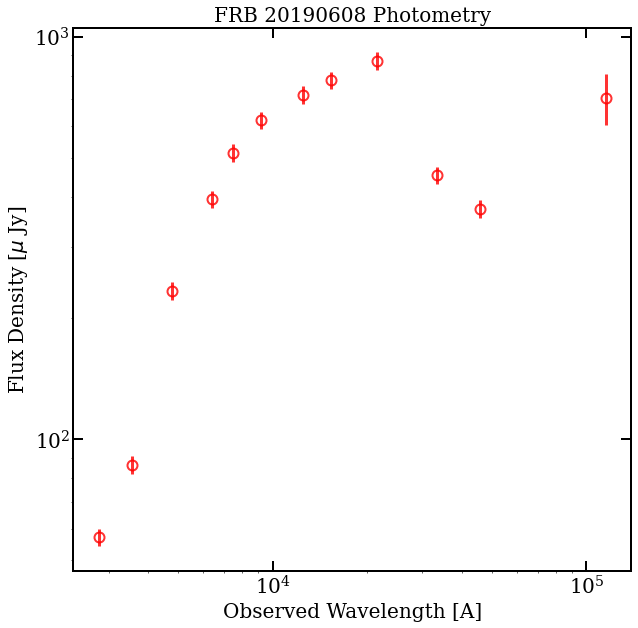

In [5]:
# Now let's plot the photometry just to see if it looks right:
fig = plt.figure(figsize=(10,10))

plt.errorbar(obs["phot_wave"], obs['maggies']*3631*1e6, yerr=obs['maggies_unc']*3631*1e6, 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=2)
plt.xlabel('Observed Wavelength [A]',fontsize =20)
plt.ylabel(r'Flux Density [$\mu$ Jy]',fontsize =20)
plt.title('FRB 20190608 Photometry',fontsize =20)
plt.xscale('log')
plt.yscale('log')

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=20, length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)


plt.show()


Ok that seems good! This FRB host also has a spectrum, which we can add in as shown below.

Note that we need the spectrum to be extinction-corrected and in a flux density/Hz unit, if your spectrum is not already in this format!

In [6]:
def load_spec_csv(filename):
        f = read_csv(filename, header=None, delimiter=',')
        f.columns = ['wavelength', 'flux', 'err']
        wave = np.array(f['wavelength'])
        flux = np.array(f['flux'])
        err = np.array(f['err'])
        return wave, flux, err
    
    
spec_wave, spec_fd, spec_fd_unc = load_spec_csv('FRB190608_prospect.csv')

This is what our spectrum looks like.

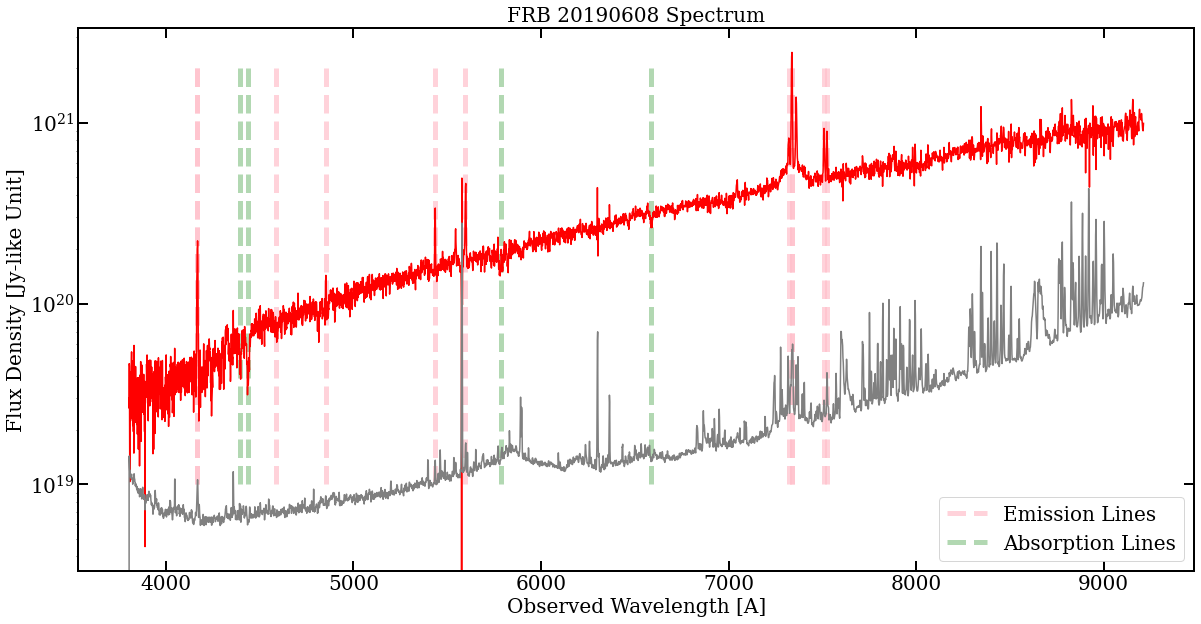

In [7]:
# Now let's plot the photometry just to see if it looks right:
fig = plt.figure(figsize=(20,10))

plt.plot(spec_wave, spec_fd, color='red')
plt.plot(spec_wave, spec_fd_unc, color='gray')

impt_em_lines = np.array([3727, 3729, 4102, 4341, 4861, 5007, 6549, 6563, 6565, 6718, 6732])
impt_abs_lines = np.array([3934, 3969, 5176, 5895])

plt.vlines(impt_em_lines*(1+obs['redshift']), 1e19, 2e21, ls ='dashed', color='pink', 
           alpha=0.7, lw=5, label='Emission Lines')
plt.vlines(impt_abs_lines*(1+obs['redshift']), 1e19, 2e21, ls ='dashed', color='green', 
           alpha=0.3, lw=5, label='Absorption Lines')

plt.xlabel('Observed Wavelength [A]',fontsize =20)
plt.ylabel(r'Flux Density [Jy-like Unit]',fontsize =20)
plt.title('FRB 20190608 Spectrum',fontsize =20)
plt.yscale('log')


plt.legend(fontsize=20, loc='lower right')

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=20, length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)


plt.show()


You'll note that there are several parts that we may want to mask out in the spectrum (e.g. regions where there is very low S/N, unmasked cosmic rays, strong telluric lines, etc.). We can mask out the regions we do not want to fit using the code below:

In [8]:
# create spectral mask
# approximate cut-off for MILES library at 7500 A rest-frame, using SDSS redshift,
# also mask Sodium D absorption
wave_rest = spec_wave / (1+obs['redshift'])
mask2 = (spec_fd_unc != 0) & \
       (spec_fd != 0) & \
       (wave_rest < 7500) & \
       (spec_wave > 4050)   

# apply standard mask
spec_wave = spec_wave[mask2]
spec_fd = spec_fd[mask2]
spec_fd_unc = spec_fd_unc[mask2]

# second mask if needed
mask = []
for i in range(len(spec_wave)):
    mask.append(True)
mask = np.array(mask)

bad_idx = np.where((spec_wave < 5582) & (spec_wave > 5572)) #2nd condition
mask[bad_idx] = False

bad_idx2 = np.where((spec_wave < 6310) & (spec_wave > 6295)) #2nd condition
mask[bad_idx2] = False

# apply second mask
obs['wavelength'] = spec_wave[mask]
obs['spectrum'] = spec_fd[mask] 
obs['unc'] = spec_fd_unc[mask] 

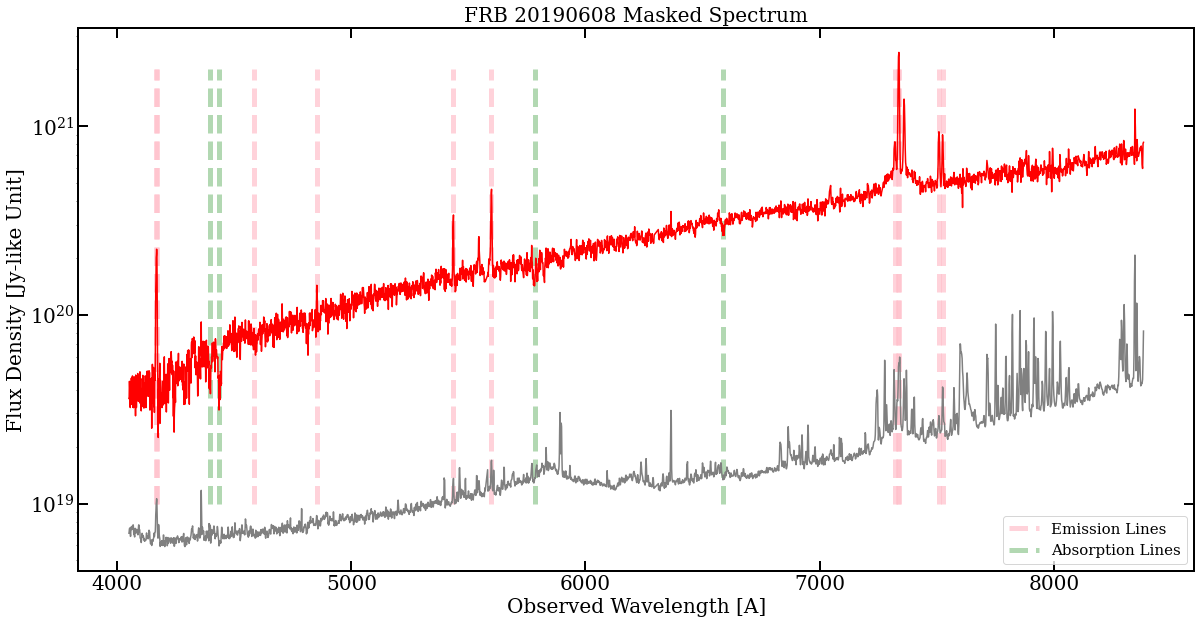

In [9]:
fig = plt.figure(figsize=(20,10))

plt.plot(obs['wavelength'], obs['spectrum'], color='red')
plt.plot(obs['wavelength'], obs['unc'], color='gray')

impt_em_lines = np.array([3727, 3729, 4102, 4341, 4861, 5007, 6549, 6563, 6565, 6718, 6732])
impt_abs_lines = np.array([3934, 3969, 5176, 5895])

plt.vlines(impt_em_lines*(1+obs['redshift']), 1e19, 2e21, ls ='dashed', color='pink', 
           alpha=0.7, lw=5, label='Emission Lines')
plt.vlines(impt_abs_lines*(1+obs['redshift']), 1e19, 2e21, ls ='dashed', color='green', 
           alpha=0.3, lw=5, label='Absorption Lines')


plt.xlabel('Observed Wavelength [A]',fontsize =20)
plt.ylabel(r'Flux Density [Jy-like Unit]',fontsize =20)
plt.title('FRB 20190608 Masked Spectrum',fontsize =20)
plt.yscale('log')

plt.legend(fontsize=15, loc='lower right')

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=20, length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)


plt.show()


Finally, the full build_obs function can be structured as shown below.

In [10]:
def build_obs(spec =True, spec_file='FRB190608_prospect.csv', maskspec=True,
              err_floor=0.05, **kwargs):
    
    """
    Load photometry and spectra
    """

    ### switch for data
    obs = {}

    # First, make a list of the filters you want and set them equal to "filternames"
    DECaL = ['decam_{}'.format(b) for b in ['g', 'r', 'z']]
    SDSS = ['sdss_{}0'.format(filt) for filt in ['u','i']]
    HST = ['wfc3_ir_f160w', 'wfc3_uvis_f300x']
    VISTA = ['VISTA_{}'.format(b) for b in ['J', 'Ks']]
    WISE = ['wise_w'+filt for filt in ['1','2','3']]

    filternames = DECaL + SDSS + HST + VISTA + WISE

    # Load in the filter transmission curves using SedPy's load_filter() function
    obs["filters"] = load_filters(filternames)

    # Find the wavelengths using .wave_effective from SedPy
    obs["phot_wave"] = [f.wave_effective for f in obs["filters"]]

    # Put in photometry magnitude points (**NOTE: NEEDS TO BE IN SAME ORDER AS FILTERS)
    M_AB = np.array([17.98, 17.41, 16.92, 19.06,  17.12, 16.67, 19.51, 16.76, 16.55, 17.26,17.47,16.78])
    M_AB_unc = np.array([0.001, 0.002, 0.001, 0.043,  0.008, 0.001, 0.014, 0.024, 0.036, 0.025,0.056,0.146])

    # Convert to flux in maggies
    mags = 10**(-0.4*M_AB)

    # Convert magnitude uncertainties to flux uncertainties
    mag_down = [x-y for (x,y) in zip(M_AB, M_AB_unc)]
    flux_down = [10**(-0.4*x) for x in mag_down]
    flux_uncertainty = [y-x for (x,y) in zip(mags, flux_down)]

    # Add in error floor
    flux_uncertainty = np.clip(flux_uncertainty, mags*err_floor, np.inf)

    obs['maggies'] = np.array(mags)
    obs['maggies_unc'] = np.array(flux_uncertainty)

    # Here we mask out any NaNs or infs
    obs['phot_mask'] = np.isfinite(np.squeeze(mags))

    # We will also put the redshift in (if its not known set it = None)
    obs['redshift'] = 0.11778 
    
    
    if spec:
        spec_wave, spec_fd, spec_fd_unc = load_spec_csv(spec_file)
    
        if maskspec:
            # create spectral mask
            # approximate cut-off for MILES library at 7500 A rest-frame, using SDSS redshift,
            # also mask Sodium D absorption
            wave_rest = spec_wave / (1+obs['redshift'])
            mask2 = (spec_fd_unc != 0) & \
                   (spec_fd != 0) & \
                   (wave_rest < 7500) & \
                   (spec_wave > 4050)   

            # apply standard mask
            spec_wave = spec_wave[mask2]
            spec_fd = spec_fd[mask2]
            spec_fd_unc = spec_fd_unc[mask2]

            # second mask if needed
            mask = []
            for i in range(len(spec_wave)):
                mask.append(True)
            mask = np.array(mask)

            bad_idx = np.where((spec_wave < 5582) & (spec_wave > 5572)) #2nd condition
            mask[bad_idx] = False

            bad_idx2 = np.where((spec_wave < 6310) & (spec_wave > 6295)) #2nd condition
            mask[bad_idx2] = False

            # apply second mask
            obs['wavelength'] = spec_wave[mask]
            obs['spectrum'] = spec_fd[mask] 
            obs['unc'] = spec_fd_unc[mask] 
            
        else:
            obs['wavelength'] = spec_wave
            obs['spectrum'] = spec_fd
            obs['unc'] = spec_fd_unc
    
    else:
        # No spectrum
        obs['wavelength'] = None
        obs['spectrum'] = None
        obs['unc'] = None
        
        
    return obs


## (3) build_model( ) function

The next most important thing is building the model, which we do in the load_model( ) function. This model is constructed using functions in Python FSPS, a stellar population synthesis code (see more: http://dfm.io/python-fsps/current/stellarpop_api/). 

The models are loaded in through a Prospector template, which we change slightly for our data. We will use the "continuity_sfh" template, which is a non-parametric star formation history.

This template looks like:

In [11]:
TemplateLibrary.describe("continuity_sfh")

Free Parameters: (name: prior) 
-----------
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  logmass: <class 'prospect.models.priors.TopHat'>(mini=7,maxi=12)
  logsfr_ratios: <class 'prospect.models.priors.StudentT'>(mean=[0. 0.],scale=[0.3 0.3],df=[2 2])

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: 0.1 
  mass: 1000000.0 <function logsfr_ratios_to_masses at 0x12ce595f0>
  sfh: 3 
  imf_type: 2 
  dust_type: 0 
  agebins: [[0.0, 8.0], [8.0, 9.0], [9.0, 10.0]] 


Before getting to the parameters we are interested in, we need to set the initial mass function (IMF), star formation history (SFH), and dust attenuation. All the different functions are assigned numbers in Python-FSPS, which you can look into more in the link above, but I will also give them here. The functions that are highlighted are the ones which I typically use.

IMF:
- (0) Salpeter
- (1) Chabrier
- (2) <font color=green>Kroupa</font>
- (3) van Dokkum
- (4) Dave (2008)
- (5) Tabulate piece-wise, power-law IMF


SFH:
- (0) Compute a simple stellar population (SSP)
- (1) Tau-model
- (2) Not an option
- <font color=green>
(3) Continuity/Non-parametric SFH</font>
- (4) Delayed-tau model ($t*e^{-t/\tau}$)
- (5) Delayed-tau model with a time sf_trunc that lead to linearly decreasing SFH

Dust Attenuation:
- (0) Power Law
- (1) Milky Way Dust Extinction Law
- (2) Calzetti et. al. Attenuation Curve 
- (3) A handful of attenuation curves from Witt and Gordon
- (4) <font color=green>Kriek and Conroy Attenuation Curve</font>


Let's get to the parameters now! Prospector allows us to have both free and fixed parameters. The "free" parameters are sent to the nested sampling routine to be iterated over to find the most probable value. The "fixed" parameters are typically parameters that we know the value of or functions that should stay constant throughout the fit (e.g., IMF, Dust Extinction Law, SFH parameterization). The parameters we are most interested in are: age, mass, metallicity, redshift, and dust extinction, and the SFR bins for the non-parametric model.

Here are the units for these parameters and how you call them in Prospector:

- Mass formed (called "mass" or "massmet_1") [M$_\odot$] - note that this is not stellar mass and will need to be converted to a stellar mass!
- Dust extinction (called "dust2"), in magnitudes, default = 0.0 ($A_V$/1.086)
- Metallicity (called "logzsol" or "massmet_2"), given by log(Z/Z$_\odot$), where Z is the metallicity, "logzsol" ranges from -1.5 to 0.2 - measured in [Fe/H]
- Redshift (called "zred"), with default z = 0.1

For the free parameters, you will want to pick ranges that are reasonable given your expectations of the galaxy, however you also want to leave them wide enough that you are not just "picking" the values you want. For example, the masses for most of our hosts will be between $10^7 M_\odot < M_* < 10^{12} M_\odot$, so that might be a reasonable range. We don't expect that the metallicity of our galaxies will be $\log(Z_*/Z_\odot) < -2.0$, so we should make sure we do not go below this value.


Another thing we may want to add is a mass-metallicity relation. Since mass and stellar metallicity are dependent on each other we can use this relation to ensure that we are only sampling realistic mass and metallicity priors. Mass is now "massmet_1" and metallicity is now "massmet_2".

We set the mass-metallicity class as follows (note: you need the gallazzi_05_massmet.txt file):

In [12]:
##### Mass-metallicity prior ######
class MassMet(priors.Prior):
    """A Gaussian prior designed to approximate the Gallazzi et al. 2005 
    stellar mass--stellar metallicity relationship.
    """

    prior_params = ['mass_mini', 'mass_maxi', 'z_mini', 'z_maxi']
    distribution = truncnorm
    massmet = np.loadtxt('gallazzi_05_massmet.txt')
    def __len__(self):
        """ Hack to work with Prospector 0.3
        """
        return 2

    def scale(self,mass):
        upper_84 = np.interp(mass, self.massmet[:,0], self.massmet[:,3]) 
        lower_16 = np.interp(mass, self.massmet[:,0], self.massmet[:,2])
        return (upper_84-lower_16)

    def loc(self,mass):
        return np.interp(mass, self.massmet[:,0], self.massmet[:,1])

    def get_args(self,mass):
        a = (self.params['z_mini'] - self.loc(mass)) / self.scale(mass)
        b = (self.params['z_maxi'] - self.loc(mass)) / self.scale(mass)
        return [a, b]

    @property
    def range(self):
        return ((self.params['mass_mini'], self.params['mass_maxi']),\
                (self.params['z_mini'], self.params['z_maxi']))

    def bounds(self, **kwargs):
        if len(kwargs) > 0:
            self.update(**kwargs)
        return self.range

    def __call__(self, x, **kwargs):
        """Compute the value of the probability density function at x and
        return the ln of that.

        :params x:
            x[0] = mass, x[1] = metallicity. Used to calculate the prior

        :param kwargs: optional
            All extra keyword arguments are used to update the `prior_params`.

        :returns lnp:
            The natural log of the prior probability at x, scalar or ndarray of
            same length as the prior object.
        """
        if len(kwargs) > 0:
            self.update(**kwargs)
        p = np.atleast_2d(np.zeros_like(x))
        a, b = self.get_args(x[...,0])
        p[...,1] = self.distribution.pdf(x[...,1], a, b, loc=self.loc(x[...,0]), scale=self.scale(x[...,0]))
        with np.errstate(invalid='ignore'):
            p[...,1] = np.log(p[...,1])
        return p

    def sample(self, nsample=None, **kwargs):
        """Draw a sample from the prior distribution.

        :param nsample: (optional)
            Unused
        """
        if len(kwargs) > 0:
            self.update(**kwargs)
        mass = np.random.uniform(low=self.params['mass_mini'],high=self.params['mass_maxi'],size=nsample)
        a, b = self.get_args(mass)
        met = self.distribution.rvs(a, b, loc=self.loc(mass), scale=self.scale(mass), size=nsample)

        return np.array([mass, met])

    def unit_transform(self, x, **kwargs):
        """Go from a value of the CDF (between 0 and 1) to the corresponding
        parameter value.

        :param x:
            A scalar or vector of same length as the Prior with values between
            zero and one corresponding to the value of the CDF.

        :returns theta:
            The parameter value corresponding to the value of the CDF given by
            `x`.
        """
        if len(kwargs) > 0:
            self.update(**kwargs)
        mass = x[0]*(self.params['mass_maxi'] - self.params['mass_mini']) + self.params['mass_mini']
        a, b = self.get_args(mass)
        met = self.distribution.ppf(x[1], a, b, loc=self.loc(mass), scale=self.scale(mass))
        return np.array([mass,met])
    
def massmet_to_logmass(massmet=None,**extras):
    return massmet[0]

def massmet_to_logzsol(massmet=None,**extras):
    return massmet[1]

Then the priors can be set as shown below. Note that we will actually want redshift to be free (with a very small prior range), to encapsulate the errors in our redshift estimates.

In [13]:
# input basic continuity SFH
model_params = TemplateLibrary["continuity_sfh"]

# fit for redshift
# use catalog value as center of the prior
zred = 0.11778
model_params["zred"]['isfree'] = True
model_params["zred"]["init"] =  zred
model_params["zred"]["prior"] = priors.TopHat(mini=zred-0.01, maxi=zred+0.01)


# mass-metallicity prior
model_params['massmet'] = {'name': 'massmet',
                           'N': 2,
                           'isfree': True,
                           "init": np.array([8.0,0.0]),
                           'prior': MassMet(z_mini=-2.00, z_maxi=0.19, mass_mini=7, mass_maxi=12)}
model_params['logmass'] = {'N': 1,
                           'isfree': False,
                           'depends_on': massmet_to_logmass,
                           'init': 10.0,
                           'units': 'Msun',
                           'prior': None}
model_params['logzsol']['depends_on'] = massmet_to_logzsol
model_params['logzsol']['isfree'] = False

We will also use a dust model that is essentially an offset from a Calzetti dust extinction law. This has three additionaly parameters:

1. dust_index = sets the offset from the Calzetti curve
2. dust1 = attenuation from young stellar light
3. dust2 = attenuation from old stellar light


We will also add in an additional parameter that will dictate the difference between dust1 and dust2 (dust1_fraction), so these parameters are dependent on each other.

In [14]:
def to_dust1(dust1_fraction=None, dust1=None, dust2=None, **extras):
    return dust1_fraction*dust2

def dust2_to_dust1(dust2=None, **kwargs):
    return dust2

In [15]:
# complexify the dust
model_params['dust_type']['init'] = 4
model_params["dust2"]["prior"] = priors.ClippedNormal(mini=0.0, maxi=4.0, mean=0.3, sigma=1)
model_params["dust_index"] = {"N": 1, 
                              "isfree": True,
                              "init": 0.0, "units": "power-law multiplication of Calzetti",
                              "prior": priors.TopHat(mini=-1.0, maxi=0.4)}

model_params['dust1'] = {"N": 1, 
                         "isfree": False, 
                         'depends_on': to_dust1,
                         "init": 0.0, "units": "optical depth towards young stars",
                         "prior": None}
model_params['dust1_fraction'] = {'N': 1,
                                  'isfree': True,
                                  'init': 1.0,
                                  'prior': priors.ClippedNormal(mini=0.0, maxi=2.0, mean=1.0, sigma=0.3)}

Another component to non-parametric model that we will need to consider is the number of age-bins over which to calculate a constant SFR and mass formation build-up. Depending on the quality of the data you have, 7-8 age-bins is typically reasonable. 

We will want to use the redshift to set the maximum age of the host, and use that to set what the age-bins should be. We also will set up the free parameters to sample the SFRs of each age bin.

One question you might have is how many agebins should you use? For a good-sized dataset with UV-IR coverage + moderate/high S/N spectrum, you can do up to 8-10 agebins. If you only have photometry, 6-7 might be better. We'll do 8 for this one.

In [16]:
def zred_to_agebins(zred=None,agebins=None,**extras):
    tuniv = cosmo.age(zred).value[0]*1e9
    tbinmax = (tuniv*0.9)
    agelims = [0.0,7.4772] + np.linspace(8.0,np.log10(tbinmax),nbins_sfh-2).tolist() + [np.log10(tuniv)]
    agebins = np.array([agelims[:-1], agelims[1:]])
    return agebins.T

def logmass_to_masses(logmass=None, logsfr_ratios=None, zred=None, **extras):
    agebins = zred_to_agebins(zred=zred)
    logsfr_ratios = np.clip(logsfr_ratios,-10,10) # numerical issues...
    nbins = agebins.shape[0]
    sratios = 10**logsfr_ratios
    dt = (10**agebins[:,1]-10**agebins[:,0])
    coeffs = np.array([ (1./np.prod(sratios[:i])) * (np.prod(dt[1:i+1]) / np.prod(dt[:i])) for i in range(nbins)])
    m1 = (10**logmass) / coeffs.sum()
    return m1 * coeffs

In [17]:
nbins_sfh = 8

model_params['agebins']['N'] = nbins_sfh
model_params['mass']['N'] = nbins_sfh
model_params['logsfr_ratios']['N'] = nbins_sfh-1
model_params['logsfr_ratios']['init'] = np.full(nbins_sfh-1,0.0) # constant SFH
model_params['logsfr_ratios']['prior'] = priors.StudentT(mean=np.full(nbins_sfh-1,0.0),
                                                                  scale=np.full(nbins_sfh-1,0.3),
                                                                  df=np.full(nbins_sfh-1,2))

model_params['agebins']['depends_on'] = zred_to_agebins
model_params['mass']['depends_on'] = logmass_to_masses

The whole build_model( ) function looks like this:

In [18]:
nbins_sfh = 8 # 7-8 bins good for phot-only, can go up to 10-12 for phot+spec
def build_model(opt_spec = True, add_duste=True, add_neb=True, add_agn=True, mixture_model=True,
                remove_spec_continuum=True,
                marginalize_neb=True, **extras):
    """Construct a model.  This method defines a number of parameter
    specification dictionaries and uses them to initialize a
    `models.sedmodel.SedModel` object.
    :param object_redshift:
        If given, given the model redshift to this value.
    :param add_dust: (optional, default: False)
        Switch to add (fixed) parameters relevant for dust emission.
    :param add_neb: (optional, default: False)
        Switch to add (fixed) parameters relevant for nebular emission, and
        turn nebular emission on.
    """

    # input basic continuity SFH
    model_params = TemplateLibrary["continuity_sfh"]

    # fit for redshift
    # use catalog value as center of the prior
    obs = build_obs()
    
    if obs['redshift'] is not None:
        # We have a redshift
        zred = obs['redshift']
        model_params["zred"]['isfree'] = True
        model_params["zred"]["init"] =  zred
        model_params["zred"]["prior"] = priors.TopHat(mini=zred-0.01, maxi=zred+0.01)
    else:
        # We do not have a redshift - set a reasonable range
        model_params["zred"]['isfree'] = True
        model_params["zred"]["prior"] = priors.TopHat(mini=0.001, maxi=0.5)

    
    # mass-metallicity prior
    # If you have reason to believe your galaxy is a dwrf, can set mass_mini = 6
    model_params['massmet'] = {'name': 'massmet',
                               'N': 2,
                               'isfree': True,
                               "init": np.array([8.0,0.0]),
                               'prior': MassMet(z_mini=-2.00, z_maxi=0.19, mass_mini=8, mass_maxi=12)}
    model_params['logmass'] = {'N': 1,
                               'isfree': False,
                               'depends_on': massmet_to_logmass,
                               'init': 10.0,
                               'units': 'Msun',
                               'prior': None}
    model_params['logzsol']['depends_on'] = massmet_to_logzsol
    model_params['logzsol']['isfree'] = False
    

    # modify to increase nbins
    model_params['agebins']['N'] = nbins_sfh
    model_params['mass']['N'] = nbins_sfh
    model_params['logsfr_ratios']['N'] = nbins_sfh-1
    model_params['logsfr_ratios']['init'] = np.full(nbins_sfh-1,0.0) # constant SFH
    model_params['logsfr_ratios']['prior'] = priors.StudentT(mean=np.full(nbins_sfh-1,0.0),
                                                                      scale=np.full(nbins_sfh-1,0.3),
                                                                      df=np.full(nbins_sfh-1,2))

    model_params['agebins']['depends_on'] = zred_to_agebins
    model_params['mass']['depends_on'] = logmass_to_masses

    # complexify the dust
    model_params['dust_type']['init'] = 4
    model_params["dust2"]["prior"] = priors.ClippedNormal(mini=0.0, maxi=4.0, mean=0.3, sigma=1)
    model_params["dust_index"] = {"N": 1, 
                                  "isfree": True,
                                  "init": 0.0, "units": "power-law multiplication of Calzetti",
                                  "prior": priors.TopHat(mini=-1.0, maxi=0.4)}

    model_params['dust1'] = {"N": 1, 
                             "isfree": False, 
                             'depends_on': to_dust1,
                             "init": 0.0, "units": "optical depth towards young stars",
                             "prior": None}
    model_params['dust1_fraction'] = {'N': 1,
                                      'isfree': True,
                                      'init': 1.0,
                                      'prior': priors.ClippedNormal(mini=0.0, maxi=2.0, mean=1.0, sigma=0.3)}

    # velocity dispersion
    print('ADDING velocity dispersion')
    model_params.update(TemplateLibrary['spectral_smoothing'])
    model_params["sigma_smooth"]["prior"] = priors.TopHat(mini=40.0, maxi=400.0)

    # Change the model parameter specifications based on some keyword arguments
    if add_duste:
        # Add dust emission (with fixed dust SED parameters)
        print('adding dust emission')
        model_params.update(TemplateLibrary["dust_emission"])
        model_params['duste_qpah']['isfree'] = True
        model_params['duste_gamma']['init'] = 0.01
        model_params['duste_qpah']['prior'] = priors.TopHat(mini=0.5, maxi=7.0)
        model_params['duste_gamma']['isfree'] = False
        #model_params['duste_gamma']['prior'] = priors.LogUniform(mini=0.001, maxi=0.5) 
        model_params['duste_umin']['isfree'] = False
        #model_params['duste_umin']['prior'] = priors.TopHat(mini=0.1, maxi=25)

    if add_agn:
        # Allow for the presence of an AGN in the mid-infrared
        print('adding an AGN component')
        model_params.update(TemplateLibrary["agn"])
        model_params['fagn']['isfree'] = True
        # note that fagn > 2 is unphysical, but it can be set arbitrarily high
        model_params['fagn']['prior'] = priors.LogUniform(mini=1e-5, maxi=2.0)
        model_params['agn_tau']['isfree'] = True
        model_params['agn_tau']['prior'] = priors.LogUniform(mini=5.0, maxi=150.)

    if add_neb:
        # Add nebular emission
        if opt_spec:
            # You have a spectrum
            model_params.update(TemplateLibrary["nebular"])
            model_params['gas_logu']['isfree'] = True
            model_params['gas_logz']['isfree'] = True
            model_params['nebemlineinspec'] = {'N': 1,
                                           'isfree': False,
                                           'init': False}
            _ = model_params["gas_logz"].pop("depends_on")

            if marginalize_neb:
                #Fit and marginalize over observed emissionlines
                model_params.update(TemplateLibrary['nebular_marginalization'])
                
                # Sets prior on emission line width
                model_params['eline_prior_width']['init'] = 1.0
                model_params['use_eline_prior']['init'] = True

            else:
                model_params['nebemlineinspec']['init'] = True
        else:
            # Photometry only fit
            # Turn nebular emission on, do not fit lines, do not fit gas-phase metallicity params
            model_params['nebemlineinspec']['init'] = False
            model_params['gas_logu']['isfree'] = False
            model_params['gas_logz']['isfree'] = False
            
    if opt_spec:
        # Only do these routines if there is a spectrum!
        
        if remove_spec_continuum:
            # This removes the continuum from the spectroscopy. Highly recommend
            # using when modeling both photometry & spectroscopy
            print('REMOVING spec continuum')
            model_params.update(TemplateLibrary['optimize_speccal'])
            model_params['spec_norm']['isfree'] = False
            model_params['spec_norm']['prior'] = priors.Normal(mean=1.0, sigma=0.3)
        
        elif remove_spec_continuum == False:
            model_params.update(TemplateLibrary["optimize_speccal"])
            # fit for normalization of spectrum
            model_params['spec_norm'] = {'N': 1,'init': 1.0,'isfree': True,'prior': 
                                     priors.Normal(sigma=0.2, mean=1.0), 'units': 'f_true/f_obs'}
            # Increase the polynomial size to 12
            model_params['polyorder'] = {'N': 1, 'init': 12,'isfree': False}
            run_params["opt_spec"] = True

        # This is a pixel outlier model. It helps to marginalize over
        # poorly modeled noise, such as residual sky lines or
        # even missing absorption lines
        if mixture_model:
            print('ADDING mixture model')
            model_params['f_outlier_spec'] = {"N": 1, 
                                              "isfree": True, 
                                              "init": 0.01,
                                              "prior": priors.TopHat(mini=1e-5, maxi=0.5)}
            model_params['nsigma_outlier_spec'] = {"N": 1, 
                                                  "isfree": False, 
                                                  "init": 50.0}
            model_params['f_outlier_phot'] = {"N": 1, 
                                              "isfree": False, 
                                              "init": 0.00,
                                              "prior": priors.TopHat(mini=0, maxi=0.5)}
            model_params['nsigma_outlier_phot'] = {"N": 1, 
                                                  "isfree": False, 
                                                  "init": 50.0}


            # This is a multiplicative noise inflation term. It inflates the noise in
            # all spectroscopic pixels as necessary to get a good fit.
            model_params['spec_jitter'] = {"N": 1, 
                                           "isfree": True, 
                                           "init": 1.0,
                                           "prior": priors.TopHat(mini=1.0, maxi=3.0)}


    # Now instantiate the model using this new dictionary of parameter specifications
    model = PolySpecModel(model_params)

    return model

You'll not that there are several other parameters that appeared in the run_params dictinary for the model: add_neb and add_dust. I have add_neb = True as I want the model spectrum to contain the details of the nebular emission. This option will make Prospector run slower, but it does give better results.

The add_dust parameter contains three other parameters we can include in the fit, if we have FIR data (ie: WISE/Spitzer) and comes from the Draine $\&$ Li dust emission model (see: https://iopscience.iop.org/article/10.1086/511055/pdf). These parameters are:
- duste_gamma: the fraction $\gamma$ of dust heated by starlight where $U > U_{\text{min}}$
- duste_umin: minimum starlight intensity $U_{\text{min}}$
- duste_qpah: the mass fraction of dust particles
Set all parameters as free parameters for the best results.

If your galaxy contains an AGN, you can apply another template to your model, which is contained in the add_agn parameter. This has two parameters which should be set free for optimal results:
- agn_tau: mid-IR optical depth
- fagn: the total luminosity of the AGN, expressed as a fraction of the bolometric stellar luminosity (so it can be greater than 1)


Now, let's explore what opt_spec == True does. We add in a new template called "optmize_speccal", which contains two relevant parameters: spec_norm and polyorder. Spec_norm controls the normalization between the model and observed spectra continnums and SHOULD ALWAYS BE 1 and set free. This is important! If it is not equal to 1, that may imply a bad model fit. The polyorder parameter is a fixed parameter which controls the polynomial order of the model spectrum continuum. I recommend using a polynomial between 8-12 depending on wavelength coverage and noisiness of your spectrum. You can also add in an option to remove the spectrum (remove_spec_continuum) which will do a better job at modeling the emission lines. "Mixture model" a pixel outlier model that helps to marginalize over poorly modeled noise, such as residual sky lines or even missing absorption lines. Finally, the jitter model is highly recommended if you have a moderate/high S/N spectrum. This essentially just inflates the noise in the spectrum so that it is not overweighted in the fit (which can lead to failure).




## Other Important Functions/ Running the Code
Other functions you will need (and should NOT change) are:

In [19]:
# --------------
# SPS Object
# --------------
def build_sps(zcontinuous=1, compute_vega_mags=False, **extras):
    sps = FastStepBasis(zcontinuous=zcontinuous,
                        compute_vega_mags=compute_vega_mags)  # special to remove redshifting issue
    return sps

# -------------------------------------------------
# Noise Model - If you are using the "jitter" model
# --------------------------------------------------
def build_noise(**extras):
    jitter = Uncorrelated(parnames = ['spec_jitter'])
    spec_noise = NoiseModel(kernels=[jitter],metric_name='unc',weight_by=['unc'])
    return spec_noise, None

# -----------------------------------------------------
# Noise Model - If you are NOT using the "jitter" model
# -----------------------------------------------------
"""
def build_noise(**extras):
    #jitter = Uncorrelated(parnames = ['spec_jitter'])
    #spec_noise = NoiseModel(kernels=[jitter],metric_name='unc',weight_by=['unc'])
    return None, None
"""

# -----------
# Everything
# ------------
def build_all(**kwargs):
    return (build_obs(**kwargs), build_model(**kwargs), build_sps(**kwargs), build_noise(**kwargs))


Now, you have your whole parameter file! See the example (param_example.py) I put in our Project folder for a clean/ non-Jupyter notebook version.

The next step is to run the code. For Cannon, your jobscript can look like. I highly recommend running the code in parallel! Please look at the param_example.py for details on what needs to be added to run in parallel.

#!/bin/bash

#SBATCH -c 20

#SBATCH -t 0-04:00

#SBATCH --mem=3250

#SBATCH -o prosp_%j.out

#SBATCH -e prosp_%j.err

#SBATCH -p itc_cluster

#SBATCH --mail-type=ALL

#SBATCH --mail-user=anya.nugent@cfa.harvard.edu

#SBATCH --account=avillar_lab

#load modules

module load python

module load intel/21.2.0-fasrc01 openmpi/4.1.1-fasrc01

export OMP_NUM_THREADS=1

conda activate prospector_env

export SPS_HOME=/n/home01/anugent/.conda/envs/prospector_env/lib/python3.12/site-packages/fsps

#run code

mpirun -np ${SLURM_NTASKS} python /n/holylabs/LABS/avillar_lab/Users/anugent/pfits/AT2022vxc/param_2022vxc.py


Prospector typically takes around 24-48 hours to converge. Your code log should contain something that looks like this:

iter: 1 | batch: 0 | nc: 1 | ncall: 1 | eff(%):  0.990 | logz: -55994850.417 +/-  0.229 | dlogz:    in

iter: 2 | batch: 0 | nc: 1 | ncall: 2 | eff(%):  1.961 | logz: -1130485.445 +/-  0.230 | dlogz:    inf

iter: 3 | batch: 0 | nc: 1 | ncall: 3 | eff(%):  2.913 | logz: -339110.154 +/-  0.230 | dlogz:    inf 

iter: 4 | batch: 0 | nc: 1 | ncall: 4 | eff(%):  3.846 | logz: -215855.564 +/-  0.230 | dlogz: 345576.

iter: 5 | batch: 0 | nc: 1 | ncall: 5 | eff(%):  4.762 | logz: -75645.956 +/-  0.231 | dlogz: 222321.8

iter: 6 | batch: 0 | nc: 1 | ncall: 6 | eff(%):  5.660 | logz: -66334.506 +/-  0.231 | dlogz: 82112.18

iter: 7 | batch: 0 | nc: 1 | ncall: 7 | eff(%):  6.542 | logz: -34836.989 +/-  0.231 | dlogz: 72800.72

iter: 8 | batch: 0 | nc: 2 | ncall: 9 | eff(%):  7.339 | logz: -12861.013 +/-  0.231 | dlogz: 41303.19

iter: 9 | batch: 0 | nc: 1 | ncall: 10 | eff(%):  8.182 | logz: -10112.327 +/-  0.232 | dlogz: 19327.2

iter: 10 | batch: 0 | nc: 1 | ncall: 11 | eff(%):  9.009 | logz: -9580.172 +/-  0.232 | dlogz: 16578.5

...

## Modeling the Fit

Woo! You did it and now you have an output file that has your converged values from the MCMC run. This file should ne named "output_filename_mcmc.h5". Now, we have to analyze this file. We will do this by creating a trace plot, corner plot, star and mass formation history plots, and SED of the observed photometry along with the model photometry and model spectroscopy.


First, lets load in all of the rest of the packages we need:

In [20]:
import os
import prospect
from prospect.utils.obsutils import fix_obs
from scipy.stats import truncnorm
from scipy.signal import savgol_filter
from prospect.utils.plotting import quantile
from sedpy.observate import load_filters
from scipy.signal import savgol_filter
from prospect.plotting.utils import sample_posterior
from astropy.cosmology import WMAP9
from prospect.io.read_results import results_from, get_sps
import prospect.io.read_results as reader
from prospect.io.read_results import traceplot, subcorner
import corner as triangle

We will also need to load in the file as well as creating a new run_params dictionary.

In [21]:
run_params = {}
file = 'FRB20190608_NP_VISTA_mask_NV_NP2_FM07_WISEAP2_mcmc.h5'

res, obs, mod = results_from(file, dangerous=False)

### Trace Plots

These plots show how the walkers moved over the parameter space per iteration. They should look like they have converged to a value for this to be a "good" fit.

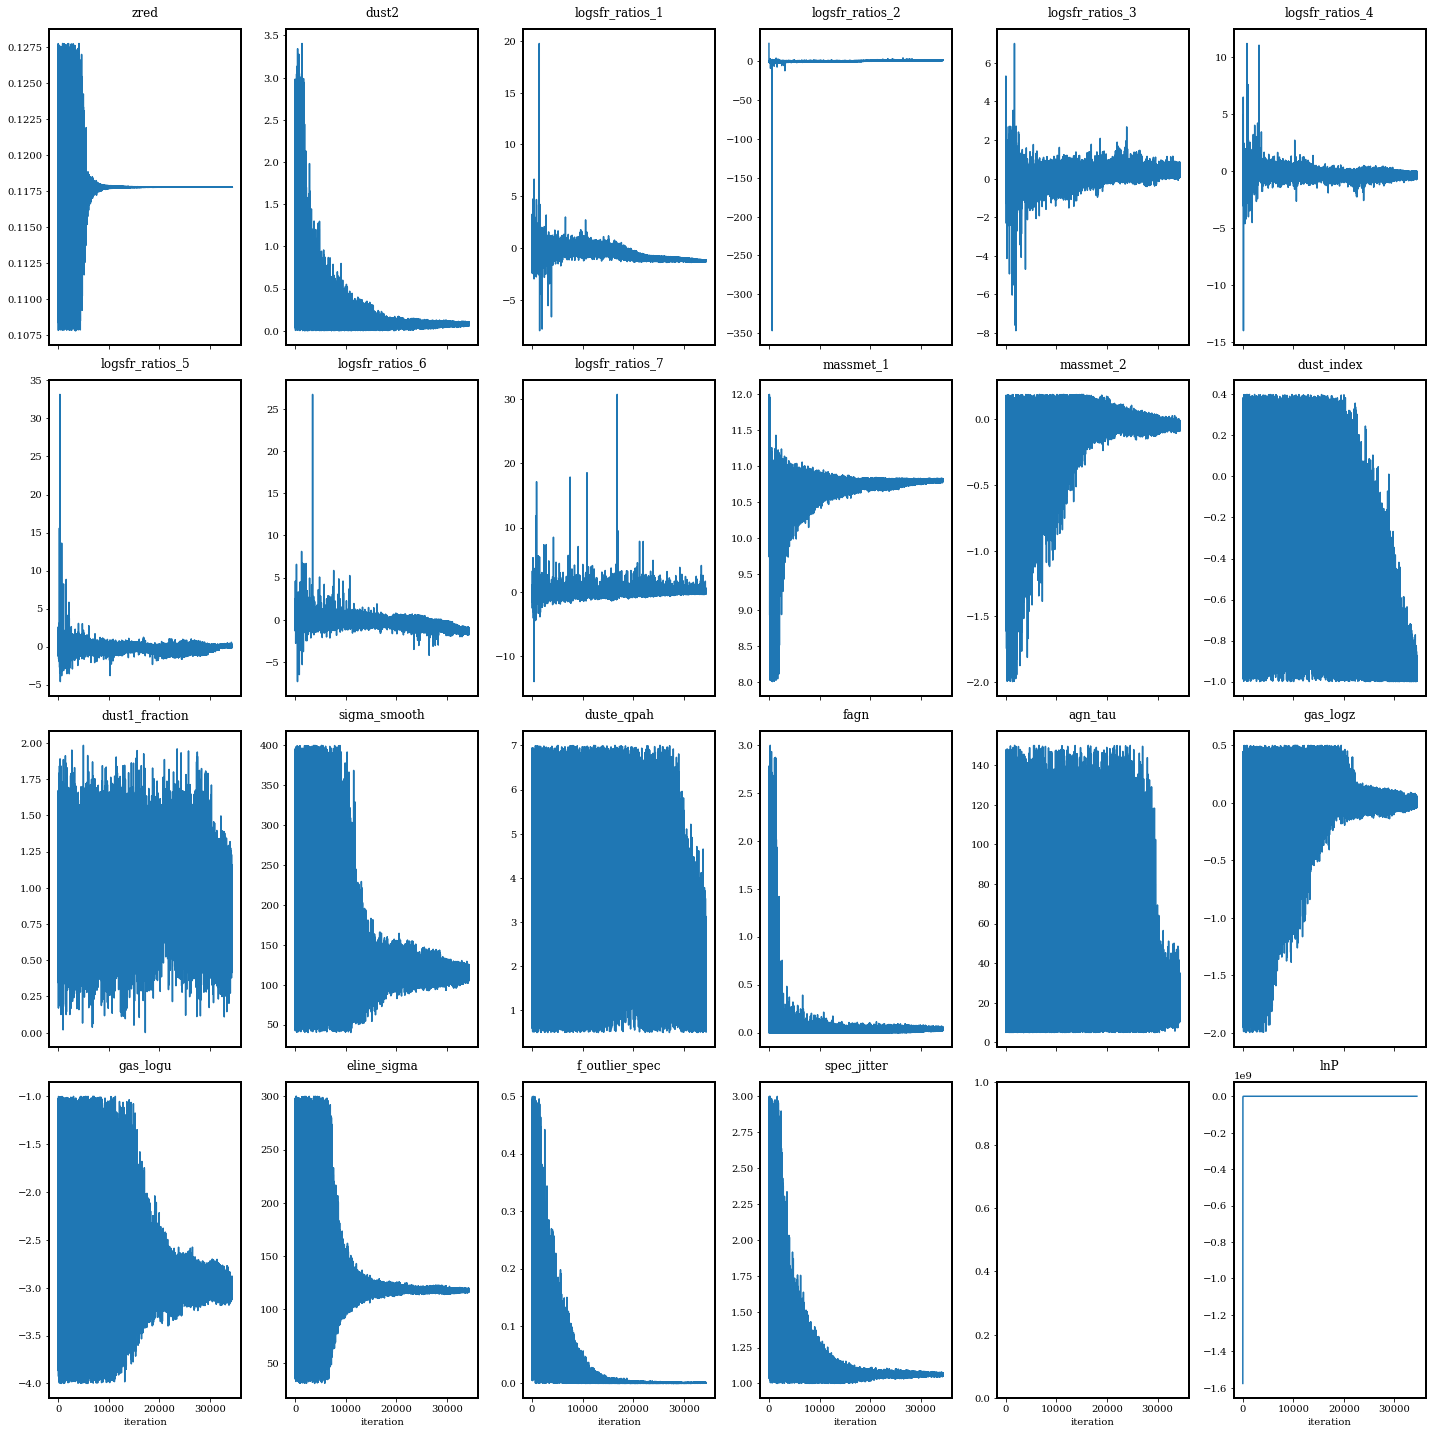

In [22]:
tracefig = traceplot(res, figsize=(20,20))

These plots look like they have somewhat converged.

Now let's look at the corner plots to see how good the histrograms are and the $1\sigma$ uncertainties for all the free parameters.

## Corner Plots

We can now make a corner plot of some of the stellar population properties of interest. For this code, we take the Prospector samples and weights and reweight them to make 100k uniform samples. This also makes it easy to compare Prospector fits of different FRB hosts!

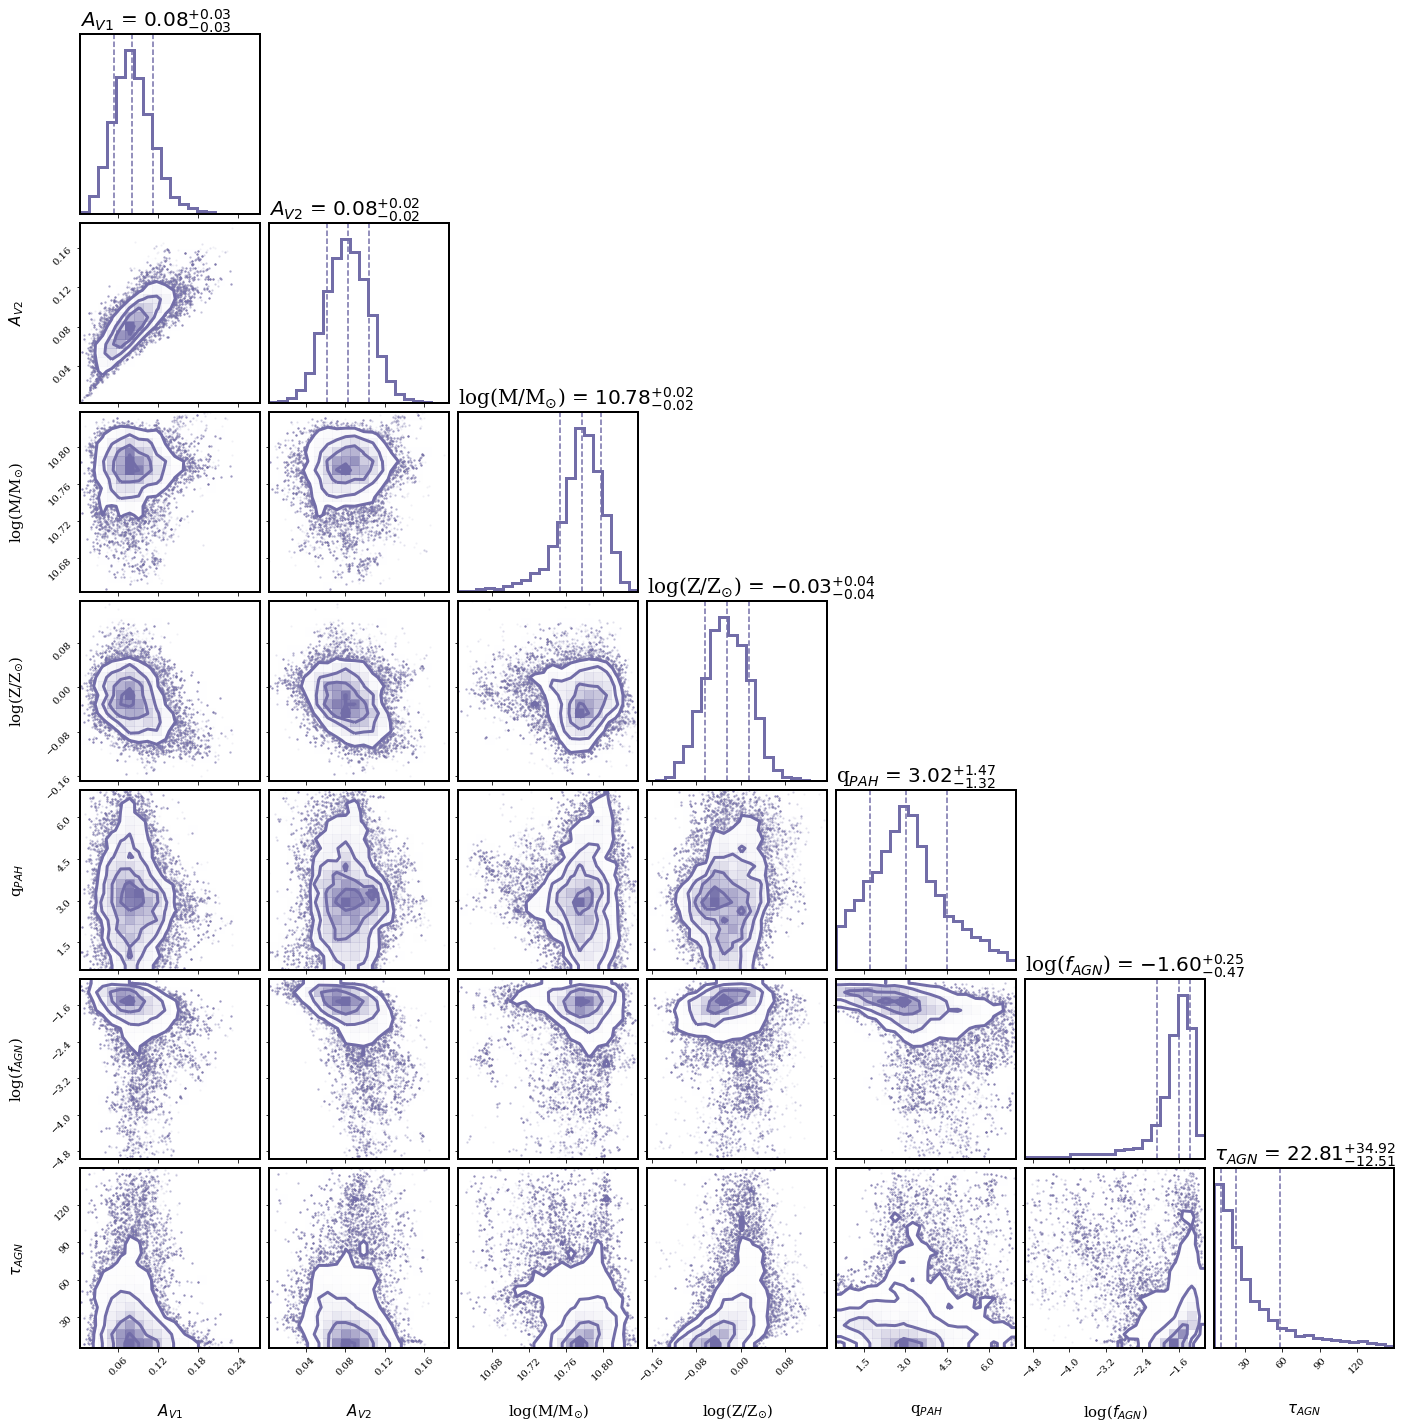

In [23]:
def cornerNP(results, param_latex, truths=None, logify=['fagn'], **kwargs):
    # Get parameter names 
    parnames = np.array(results['theta_labels'], dtype='U20')

     # Get the arrays we need (trace, wghts)
    samples = results['chain']
    xx = samples.copy()
    wghts = results.get('weights', None)
    
    # logify some parameters
    xx = samples.copy()
    if truths is not None:
        xx_truth = np.array(truths).copy()
    else:
        xx_truth = None
    for p in logify:
        if p in parnames:
            idx = parnames.tolist().index(p)
            xx[:, idx] = np.log10(xx[:,idx])
            parnames[idx] = "log({})".format(parnames[idx])
            if truths is not None:
                xx_truth[idx] = np.log10(xx_truth[idx])

    # Resample posterior using weights to 100k uniformly-sampled weights    
    theta_samp = sample_posterior(xx, weights=wghts, nsample=100000)

    # convert dust2 to AV
    dust2 = theta_samp[:, parnames.tolist().index('dust2')]*1.086
    
    # nicer names
    mass_log = theta_samp[:, parnames.tolist().index('massmet_1')]
    logzsol = theta_samp[:, parnames.tolist().index('massmet_2')]
    #gaslogz = theta_samp[:, parnames.tolist().index('gas_logz')]
    fagn = theta_samp[:, parnames.tolist().index('log(fagn)')]
    tau_agn = theta_samp[:, parnames.tolist().index('agn_tau')]
    #duste_umin = theta_samp[:, parnames.tolist().index('duste_umin')]
    duste_qpah = theta_samp[:, parnames.tolist().index('duste_qpah')]
    #duste_gamma = theta_samp[:, parnames.tolist().index('duste_gamma')]
    dust1= np.array(theta_samp[:, parnames.tolist().index('dust1_fraction')])*np.array(dust2)
    
    
    # choose which parameters to plot
    new_theta = []
    for i in np.arange(0, len(mass_log), 1):
        new_idx = [dust1[i], dust2[i], mass_log[i], logzsol[i], duste_qpah[i], fagn[i], tau_agn[i]]
        new_theta.append(new_idx)
    
    
    # plot figure
    figure = triangle.corner(new_theta, quantiles=[0.16, 0.50, 0.84], show_titles=True, labels = param_latex,
                             color = '#726DA8', hist_kwargs = {"alpha": 1, "linewidth":3}, 
                             title_fmt = ' .2f', contour_kwargs={"linewidths":3}, **kwargs)
    return figure

# nice latex names
#platex = np.array([r'$A_{V,old}$', r'log(M/M$_{\odot}$)', r'log(Z/Z$_{\odot}$)', r'log($Z_{gas}$)', r'log($f_{AGN}$)', 
#                   r'$\tau_{AGN}$', 'U$_{min}$', 'q$_{PAH}$', '$\gamma$'], dtype='U20')

platex = np.array([r'$A_{V1}$', r'$A_{V2}$', r'log(M/M$_{\odot}$)', r'log(Z/Z$_{\odot}$)', 
                   'q$_{PAH}$',r'log($f_{AGN}$)', r'$\tau_{AGN}$'], dtype='U20')
#r'log($Z_{gas}$)', r'log($f_{AGN}$)', r'$\tau_{AGN}$'

cornerfig = cornerNP(res, platex, fig=plt.subplots(7,7,figsize=(20,20))[0],
                     title_kwargs={"fontsize":20, 'loc':'left'},
                     label_kwargs={"fontsize":15, 'labelpad':30}, label_fmt=" .2f")
plt.show(cornerfig)

# Stellar Mass

The stellar mass is fairly easily retrieved from the Prospector fit. You just need to do a model call to get the model spectrum, photometry, and fraction of surviving stellar mass in the galaxy. Then, you can get all of your uniformly sampled mass formed values ('massmet_1') and determine the stellar mass at each of these points to get a posterior distribution in stellar mass.

In [24]:
# Model Call
mod = build_model(**run_params)
# SPS Call
sps = build_sps(**run_params)

ADDING velocity dispersion
adding dust emission
adding an AGN component
REMOVING spec continuum
ADDING mixture model


In [25]:
spec, phot, mfrac = mod.predict(mod.theta, obs=obs, sps=sps)

ncalc = 100000 # number of samples to generate
npoints = res['chain'].shape[0]
parnames = np.array(res['theta_labels'], dtype='U20')
sample_idx = np.random.choice(np.arange(npoints),size=ncalc,p=res['weights'],replace=True)
thetas = res['chain'][sample_idx,:]

surviving_mass = []
for theta in thetas:
    surviving_mass.append(np.sum(10**theta[parnames.tolist().index('massmet_1')]) * mfrac)
    
surviving_mass = []
for theta in thetas:
    surviving_mass.append(np.sum(10**theta[parnames.tolist().index('massmet_1')]) * mfrac)

In [26]:
sm_q16 = np.log10(np.quantile(surviving_mass, q=0.16))
sm_q50 = np.log10(np.quantile(surviving_mass, q=0.50))
sm_q84 = np.log10(np.quantile(surviving_mass, q=0.84))

print('Stellar Mass: {a} + {b} /- {c}'.format(a=sm_q50, b=sm_q84-sm_q50, c=sm_q50-sm_q16))

Stellar Mass: 10.575700182696862 + 0.01985547928379816 /- 0.024354717894313538


# Star Formation History and Mass Formation History

Now, we want to calculate the star formation history using the age-bins and the SFR ratios Prospector determined per age-bin. There are some Prospector equations to help you convert the output to SFRs per age-bin. In this case, we want to make sure that:

1. logmass = samples where 'massmet_1' is 
2. logsfr_ratios = samples where all SFR ratios are held


Make sure that you are passing the right variable to the function or else this will not work (and it may be different than what I have here!!).

In [27]:
ncalc = 100000 # number of samples to generate
npoints = res['chain'].shape[0]
resc = res['chain']
parnames = np.array(res['theta_labels'], dtype='U20')
agebins = zred_to_agebins(zred=[obs['redshift']])
weights = res.get('weights', None)
sample_idx = np.random.choice(np.arange(npoints),size=ncalc,p=res['weights'],replace=True)
thetas = res['chain'][sample_idx,:]

SFR = []
MASS = []
sfr = np.zeros((npoints, nbins_sfh))
mass = np.zeros((npoints, nbins_sfh)) 


for sample in sample_idx:
    sfr[sample] = prospect.models.transforms.logsfr_ratios_to_sfrs(logmass=resc[sample][8],logsfr_ratios=[resc[sample][1], resc[sample][2],
                                                                       resc[sample][3], resc[sample][4], resc[sample][5], resc[sample][6], 
                                                                       resc[sample][7]], agebins=agebins)
    SFR.append(sfr[sample])
    mass[sample] = prospect.models.transforms.logsfr_ratios_to_masses(logmass=resc[sample][8],logsfr_ratios=[resc[sample][1], resc[sample][2],
                                                                       resc[sample][3], resc[sample][4], resc[sample][5], resc[sample][6], 
                                                                       resc[sample][7]], agebins=agebins)
    MASS.append(mass[sample])

Now, we can convert this into quantiles for each age-bin.

In [28]:
# Now we have a numpy array of the mass and SFR in each bin
star_formation = [list(j) for j in SFR]
s_mass = [list(j) for j in MASS]
npSFR = np.array(star_formation, dtype=float)
npSM = np.array(s_mass, dtype=float)

#Calculate the quantiles
Q16_SFR = [quantile(npSFR[:, i], percents=16, weights = res.get("WEIGHTS", None))
             for i in range(nbins_sfh)]
             
Q50_SFR = [quantile(npSFR[:, i], percents=50, weights = res.get("WEIGHTS", None))
             for i in range(nbins_sfh)]

Q84_SFR = [quantile(npSFR[:, i], percents=84, weights=res.get("WEIGHTS", None))
             for i in range(nbins_sfh)]      

Q16_Mass = [quantile(npSM[:, i], percents=16, weights = res.get("WEIGHTS", None))
             for i in range(nbins_sfh)]

Q50_Mass = [quantile(npSM[:, i], percents=50, weights = res.get("WEIGHTS", None))
             for i in range(nbins_sfh)]

Q84_Mass = [quantile(npSM[:, i], percents=84, weights = res.get("WEIGHTS", None))
             for i in range(nbins_sfh)]

<Figure size 720x720 with 0 Axes>

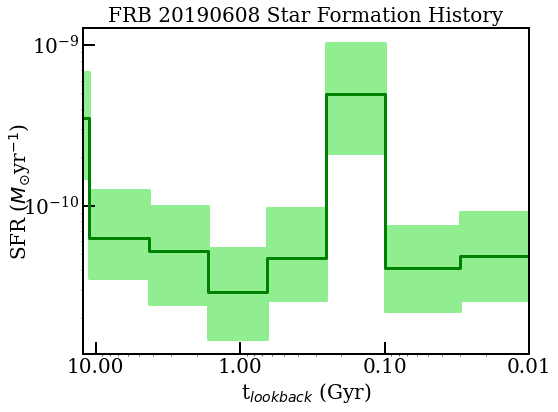

In [29]:
import matplotlib as mpl
from functools import partial

fig = plt.figure(figsize=[10,10])

# Age bins
x_log = [age[0] for age in agebins]
x_log = np.append(x_log, agebins[-1][-1]) # double last bin for plot purposes
x_log[0]=0  # set age range for aesthetic purposes

x = (10**x_log)/1e9 # de-log agebins (in yr) and convert to Gyr

# 16th percentile of SFR
y_lower = np.insert(Q16_SFR, 0, Q16_SFR[0], axis=0)
# 50th percentile of SFR
y = np.insert(Q50_SFR, 0, Q50_SFR[0], axis=0)
# 84th percentile of SFR
y_upper = np.insert(Q84_SFR, 0, Q84_SFR[0], axis=0)

# plot details
fig, ax = plt.subplots(figsize=[8,6])
plt.title('FRB 20190608 Star Formation History', fontsize = 20)
plt.xlabel('t$_{lookback}$ (Gyr)', fontsize = 20)
plt.ylabel('SFR ($M_{\odot}$yr$^{-1}$)', fontsize = 20)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.minor.width'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['ytick.major.width'] = 3
ax.tick_params(axis='x', which='minor')

# use step function to generate the SFH plot
plt.step(x, y_lower, alpha = 1, c = 'lightgreen', linewidth=3)
plt.step(x, y_upper, alpha = 1, c = 'lightgreen', linewidth=3)
plt.step(x, y, alpha = 1.0, c = 'green', linewidth=3)

# Since it's the lookback time, we want the x-axis limits to be flipped
plt.xlim(x[-1], 0.01) # setting max for aesthetic purposes
#plt.xscale('log')
plt.yscale('log')

import matplotlib.ticker as mticker

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=20, length=12, width=2, direction='in')
    ax.set_xscale('log')
    ax.set_xticks([0.01, 0.1, 1, 10])
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.xaxis.get_major_formatter().set_scientific(False)
    ax.xaxis.get_major_formatter().set_useOffset(False)
    #ax.xaxis.set_minor_formatter(mticker.ScalarFormatter(False))
    
    
    ax.yaxis.labelpad = -10

# shading the regions between 16th and 84th percentiles
plt.fill_between(x,y_lower,y_upper, where=None,interpolate=False,step='pre',color="lightgreen")

plt.show()


<Figure size 720x720 with 0 Axes>

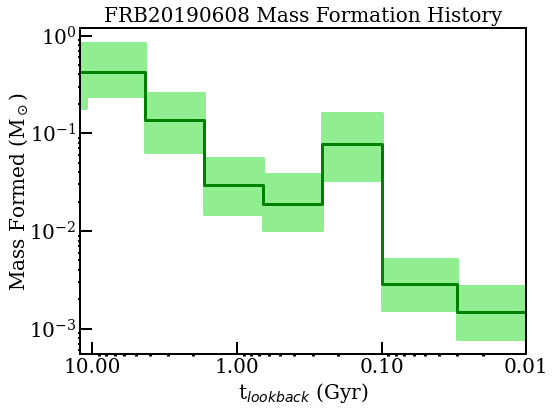

In [30]:
fig = plt.figure(figsize=[10,10])

# Age bins
x_log = [age[0] for age in agebins]
x_log = np.append(x_log, agebins[-1][-1]) # double last bin for plot purposes
x_log[0]=0  # set age range for aesthetic purposes

x = (10**x_log)/1e9 # de-log agebins (in yr) and convert to Gyr

# 16th percentile of SFR
w_lower = np.insert(Q16_Mass, 0, Q16_Mass[0], axis=0)
# 50th percentile of SFR
w = np.insert(Q50_Mass, 0, Q50_Mass[0], axis=0)
# 84th percentile of SFR
w_upper = np.insert(Q84_Mass, 0, Q84_Mass[0], axis=0)

# plot details
fig, ax = plt.subplots(figsize=[8,6])
plt.title('FRB20190608 Mass Formation History', fontsize = 20)
plt.xlabel('t$_{lookback}$ (Gyr)', fontsize = 20)
plt.ylabel('Mass Formed (M$_\odot$)', fontsize = 20)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.minor.width'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['ytick.major.width'] = 3
ax.tick_params(axis='x', which='minor')

# use step function to generate the SFH plot
plt.step(x, w_lower, alpha = 1, c = 'lightgreen', linewidth=3)
plt.step(x, w_upper, alpha = 1, c = 'lightgreen', linewidth=3)
plt.step(x, w, alpha = 1.0, c = 'green', linewidth=3)

# Since it's the lookback time, we want the x-axis limits to be flipped
plt.xlim(x[-1], 0.01) # setting max for aesthetic purposes
#plt.xscale('log')
plt.yscale('log')

import matplotlib.ticker as mticker

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=20, length=12, width=2, direction='in')
    ax.set_xscale('log')
    ax.set_xticks([0.01, 0.1, 1, 10])
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.xaxis.get_major_formatter().set_scientific(False)
    ax.xaxis.get_major_formatter().set_useOffset(False)
    #ax.xaxis.set_minor_formatter(mticker.ScalarFormatter(False))
    ax.yaxis.labelpad = -1

# shading the regions between 16th and 84th percentiles
plt.fill_between(x,w_lower,w_upper, where=None,interpolate=False,step='pre',color='lightgreen')


plt.show()


# Mass-Weighted Age

The next thing we want to do is calculate the mass-weighted age of the host galaxy. The mass-weighted age can be thought of as the median age of all of the stellar populations within the galaxy, and is therefore typically used to estimate the galaxy's true age. This can also be used as a proxy for the delay time of a transient progenitor.

The mass-weighted age is given by:
\begin{equation*}
t_m = \sum ( M_n * t_n ) / M_{total},
\end{equation*}

where n represents the age-bin.

In [31]:
# =============================================================================
# Calculate mass-weighted age
#
# Eqn: t_m = sum(m_n * age_n)/m_total for n age bins
#
# Non-parametric mass-weighted age is typically older than parametric, usually
# by a factor of 2.
#
# =============================================================================

# new method
SFR = []
sfr = np.zeros((len(weights), nbins_sfh)) # change to number of bins
                
# use the length of the weight and make the transformation from log(SFR_ratio) to SFR and total mass
# formed in each time bin
for i in range(len(weights)): # add/remove resc[i][#] to match how many bins you have; make sure to pull correct indices
    sfr[i] = prospect.models.transforms.logsfr_ratios_to_sfrs(logmass=resc[i][8],logsfr_ratios=[resc[i][1], resc[i][2], resc[i][3], resc[i][4], resc[i][5], resc[i][6], resc[i][7]], agebins=agebins)
    SFR.append(sfr[i])
    
# Now we have a numpy array of the mass and SFR in each bin
star_formation = [list(j) for j in SFR]
npSFR = np.array(star_formation, dtype=float)
MWA = []

ages = 10**(agebins)
dtsq = (ages[:,1]**2 - ages[:,0]**2)/2

for i,sfr in enumerate(npSFR):
    mwa = (dtsq*sfr).sum()/10**resc[i][8] # make sure to pull mass
    MWA.append(mwa)
    
MWA = np.array(MWA,dtype=float)


Q16_mwa = np.quantile(MWA, 0.16)
Q50_mwa = np.quantile(MWA, 0.50)
Q84_mwa = np.quantile(MWA, 0.84)
mwa_upper = (Q84_mwa/1e9)-(Q50_mwa/1e9)
mwa_lower = (Q50_mwa/1e9)-(Q16_mwa/1e9)
print('The age of the galaxy is ' , str(round(Q50_mwa/1e9,2)), ' +',str(round(mwa_upper,2)), '/-' , str(round(mwa_lower,2)), 'Gyr' )

The age of the galaxy is  7.16  + 0.77 /- 0.95 Gyr


## SED

Now lets create the SED to see how well our observed data fits to the model. We want to build the model spectrum and photometry from the median values or the converged values that we see in the corner plots. We do this by calling the function "quantile" in Prospector and using the 50th percentile values, which re the converged values. We can take a look at how we do this below:

In [32]:
flatchain = res['chain']

from prospect.utils.plotting import quantile
post_pcts = [quantile(flatchain[:, i], percents=50, weights=res.get("weights", None))
             for i in range(mod.ndim)]

# These should have all the converged values
print(post_pcts)

mspec_conv, mphot_conv, _ = mod.mean_model(post_pcts, obs, sps=sps)
print(mphot_conv)

[0.11777960159304292, 0.07597456110667572, -1.0703709145787972, 0.9674338504385653, 0.20894177407507372, -0.22646892203235067, -0.019028185942090676, -0.7389683904426652, 0.06600604907394418, 10.777561286766735, -0.025180454536395943, -0.7746296402131133, 1.0023411974336232, 114.58772266960693, 3.0240022749119855, 0.024883979764663507, 22.785310792929568, 0.021947033963860545, -2.9281513404807513, 118.49510703899166, 0.0009668766143313067, 1.0624125686539099]
[1.06276101e-10 1.71598362e-10 2.78915806e-10 4.09731034e-11
 2.14226613e-10 3.84081373e-10 2.93313749e-11 3.64637223e-10
 3.94143954e-10 2.24202527e-10 1.60972229e-10 3.35254353e-10]


I have made a function below to automate the model photometry and spectrum in micro-Jansky units!

In [33]:
# =============================================================================
# Make the SED
# =============================================================================

def makeSED(result, obs_dict, model, stellarpop):
    flatchain = result['chain']
    
    post_pcts = [quantile(flatchain[:, i], percents=50, weights=result.get("weights", None))
                  for i in range(model.ndim)]
    
    filternames = obs_dict['filternames']
    obs_dict["filters"] = sedpy.observate.load_filters(filternames)
    
    # Iterate through thetas to fix offset issue - this will take a while
    for i in range(500):
        theta = flatchain[-i,:]
        _,_,_ = model.mean_model(theta, obs=obs_dict, sps=stellarpop)
    
    mspec_conv, mphot_conv, _ = model.mean_model(post_pcts, obs_dict, sps=stellarpop)

    # Photometry
    wphot = obs_dict["wave_effective"] # Model/Observed photometric wavelengths
    obsphot = obs_dict['maggies']*3631e6 # Converted Observed photometry
    obsphot_unc = obs_dict['maggies_unc']*3631e6 # Converted Observed Photometry error
    modphot = mphot_conv * 3631e6

    fin_dict = {'wave_effective': wphot,
                'obs_phot': obsphot,
                'obs_phot_unc': obsphot_unc,
                'model_phot': modphot}

    # If observed spectrum was used in fit
    if obs['wavelength'] is not None:
        obswave = obs_dict['wavelength'] # Observed Spectrum Wavelengths
        mod_cal = model._speccal # Normalization factor
        full_mod_spec = (model._norm_spec)*3631e6 # Already normalized model spectrum
        mspec_conv = (mspec_conv/mod_cal) * 3631e6 # Normalized model spectrum
        wfull = stellarpop.wavelengths.copy()*(1+model.params.get('zred')) # Full wavelength range
        wspec = obs_dict["wavelength"] # Observed spec wavelength
        obsspec = (obs_dict['spectrum']/mod_cal) * 3631e6 #Observed Spectrum
        obserr = (obs_dict['unc']/mod_cal) * 3631e6 # Observed Spectrum Error

        fin_dict['model_spec'] = full_mod_spec
        fin_dict['mspec_conv'] = mspec_conv
        fin_dict['obs_spec'] = obsspec
        fin_dict['obs_spec_err'] = obserr
        fin_dict['spec_wave'] = wspec 
        fin_dict['full_spec_wave'] = wfull
        fin_dict['mod_cal'] = mod_cal
        fin_dict['mspecconv'] = mspec_conv
        
    # If observed spectrum was NOT used in fit
    else:
        a = 1 + model.params.get('zred')
        wspec = stellarpop.wavelengths.copy()
        wspec *= a #redshift them
        mspec_conv *= 3631e6 # Converted model spectrum

        fin_dict['model_spec'] = mspec_conv
        fin_dict['spec_wave'] = wspec
    
    return fin_dict

In [34]:
fin = makeSED(result = res, obs_dict = obs, model = mod, stellarpop = sps)

In [35]:
try:
    if obs['spectrum'] == None:
        spec_run_bool = False # phot + spec fit
        phot_run_bool = True
except ValueError:
    spec_run_bool = True # normal phot only fit
    phot_run_bool = False # normal phot only fit
    
print(spec_run_bool)

True


Now, we can plot all of these values!

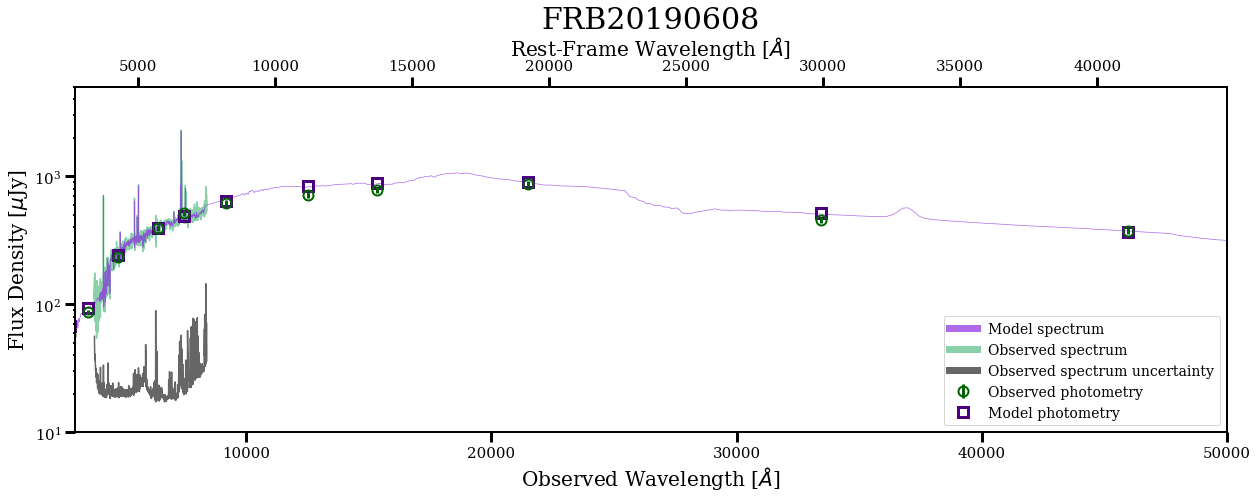

In [36]:
fig = plt.figure(figsize=(20,12))

# Set observed wavelength min and max
obs_wmin = 3.0e3
obs_wmax = 50e3

# Convert to rest-frame min and max for second axis
zred = mod.params.get('zred') # redshift
RF_wmin = obs_wmin/(1+zred)
RF_wmax = obs_wmax/(1+zred)

ax1 = fig.add_axes([0.1, 0.3, 0.8, 0.4],
                   xlim=(obs_wmin, obs_wmax), ylim =(1e1, 5e3))
ax2 = ax1.twiny()

# Axis 3 info (top of figure)
ax1.set_xlabel(r'Observed Wavelength [$\AA$]',fontsize =20)  

ax2.set_xlabel(r'Rest-Frame Wavelength [$\AA$]',fontsize =20)  
ax2.tick_params(axis='x')
ax2.set_xlim((RF_wmin,RF_wmax))


# Observed photometry 
ax1.errorbar(fin['wave_effective'], fin['obs_phot'], yerr = fin['obs_phot_unc'], 
          label='Observed photometry', ecolor='darkgreen', 
          marker='o', markersize=10, ls='', lw=3, alpha=1.0, 
          markerfacecolor='none', markeredgecolor='darkgreen', markeredgewidth=2, zorder=4) 





# Model photometry 
ax1.errorbar(fin['wave_effective'], fin['model_phot'], label='Model photometry',
              marker='s', markersize=10, alpha=1.0, ls='', lw=3, 
              markerfacecolor='none', markeredgecolor='indigo', markeredgewidth=3, zorder=3)


if spec_run_bool == True:
    
    em_model = True
    
    if em_model:
        # If you used an emission line model
        smooth_by = 5
        smooth_mod = savgol_filter(fin['model_spec'], window_length=smooth_by, polyorder=3, deriv=0, delta=1.0)
        smooth_em_mod = savgol_filter(fin['mspecconv'], window_length=smooth_by, polyorder=3, deriv=0, delta=1.0)
        
        wspec_chop = fin['spec_wave'][np.where((fin['spec_wave'] > 4000) & (fin['spec_wave'] < 9800))]
        mspec_chop = smooth_em_mod[np.where((fin['spec_wave'] > 4000) & (fin['spec_wave'] < 9800))]
        
        wspec_full = np.array(fin['full_spec_wave'])
        
        emfull_wspec = np.concatenate((wspec_full[np.where(wspec_full < 4000)], wspec_chop,  
                                       wspec_full[np.where(wspec_full > 9800)]))
        
        emfull_mspec = np.concatenate((smooth_mod[np.where(wspec_full < 4000)], mspec_chop,  
                                       smooth_mod[np.where(wspec_full > 9800)]))
    

        ax1.semilogy(emfull_wspec, emfull_mspec, label='Model spectrum',
                      lw=0.7, color='blueviolet', alpha=0.7, zorder=2) 
    else:
        smooth_by = 5
        smooth_mod = savgol_filter(fin['model_spec'], window_length=smooth_by, polyorder=3, deriv=0, delta=1.0)
        ax1.semilogy(fin['full_spec_wave'], smooth_mod, label='Model spectrum',
                  lw=0.7, color='blueviolet', alpha=0.7, zorder=2) 
        
    # Observed spectrum
    smooth_spec = savgol_filter(fin['obs_spec'], window_length=smooth_by, polyorder=3, deriv=0, delta=1.0)
    smooth_err = savgol_filter(fin['obs_spec_err'], window_length=smooth_by, polyorder=3, deriv=0, delta=1.0)

    masked = True
    if masked == True:

        mask = np.array(obs['mask'])

        smooth_wave = fin['spec_wave'][np.where(mask == True)]
        smooth_spec = smooth_spec[np.where(mask == True)]
        smooth_err = smooth_err[np.where(mask == True)]

    # Observed spectroscopy and error
    ax1.semilogy(smooth_wave, smooth_spec, color='mediumseagreen', alpha=0.6, 
                  zorder=1, label='Observed spectrum') # binned spec

    ax1.semilogy(smooth_wave, smooth_err, color='k', alpha=0.6, 
                  zorder=0, label='Observed spectrum uncertainty')
    
    
if spec_run_bool == False:
    # Model spectroscopy
    ax1.semilogy(fin['spec_wave'], fin['model_spec'], label='Model spectrum',
                  lw=0.7, color='blueviolet', alpha=0.7, zorder=2) 

from matplotlib.legend_handler import HandlerLine2D
def update(handle, orig):
    handle.update_from(orig)
    handle.set_linewidth(7)

# Axis 1 info
ax1.legend(loc='lower right', fontsize=14,handler_map={plt.Line2D : HandlerLine2D(update_func=update)})
ax1.set_ylabel(r'Flux Density [$\mu$Jy]', fontsize=20)
ax1.set_title('FRB20190608', fontsize=30)


import matplotlib.pyplot as plt

ax = plt.gca()

import matplotlib.axes

ax1.tick_params(width=3, length=10, labelsize=15)
ax2.tick_params(width=3, length=10, labelsize=15)


#plt.savefig('FRB20190608_SED.png', dpi=300)

plt.show()

We want to see that the model matches the observed photometry well - all the values should line up closely to determine whether or not this was a good fit. A few things could be going wrong if it doesn't - 

(1) Re-check all your photometry! Prospector may land on unreasonable SFRs and ages if the photometry in the UV/IR is bad.

(2) Is your spectrum several magnitudes of mu-Jy off from the model/photometry? This probably just means you loaded in the wrong model (has to be an exact match to the one you used in the fit)!

(3) Did you do a photometry-only fit and that looked better than when adding in the spectrum? This probably means you need the jitter model (inflates noise of the spectrum so it doesn't overweight the spec in the fit) if you did not use it. It could also mean that you have poorly masked cosmic rays and telluric lines that should be masked.

(4) Is the fit overall good but a few photometric points lie above the model? This probably means that an emission line overlaps with that band.

# What to do with Emission Lines?

Emission line fluxes are great if you're interested in plotting your sample on a BPT diagram or calculating SFRs from H-alpha or OII! I'll show a quick example for how to get the fluxes and calculate SFRs.

In [38]:
# =============================================================================
# Nebular Emission Line Marginalization
#
# Note that this will take a while to do the sampling, so it is recommended
# to only do this process once, and comment this section out if other plots
# need to be re-run
#
# =============================================================================
import pandas
import pandas as pd

ncalc = 1000 # number of samples to generate
npoints = res['chain'].shape[0]
parnames = np.array(res['theta_labels'], dtype='U20')
sample_idx = np.random.choice(np.arange(npoints),size=ncalc,p=res['weights'],replace=False)
thetas = res['chain'][sample_idx,:]
all_fluxes = []

# Iterate through samples to derive fluxes from a representative sample
for theta in thetas:
    spec,mags,sm = mod.predict(theta,sps=sps,obs=obs)
    ewave, emission_line_luminosities = sps.get_galaxy_elines()
    mass = theta[parnames.tolist().index('massmet_1')]
    emission_line_fluxes = (emission_line_luminosities*3.839e33*10**(mass))/(9.461e26)**2
    all_fluxes.append(emission_line_fluxes)# =+ emission_line_fluxes

# Calculate the quantiles to get upper and lower limits
flux_arr = np.array(all_fluxes,dtype=float)
Q16_flux = np.quantile(flux_arr, 0.16, axis=0)
Q50_flux = np.quantile(flux_arr, 0.50, axis=0)
Q84_flux = np.quantile(flux_arr, 0.84, axis=0)
flux_upper = Q84_flux - Q50_flux
flux_lower = Q50_flux - Q16_flux

# Save as csv with line labels
df = pandas.DataFrame({"Flux [erg/s/cm^2]" : Q50_flux, "Upper" : flux_upper, "Lower" : flux_lower})
key = pandas.read_csv('emlines_info.dat', header=None, names=['Restframe [A]', 'Line Name'])
emline_fluxes = pd.concat([key, df], axis=1)
emline_fluxes.to_csv(os.path.basename(file)[0:-16]+"_emline_fluxes.csv", index=False)
print('Emission line data saved to csv')

Emission line data saved to csv


In [40]:
# load in converted fluxes
fluxes = read_csv('FRB20190608_NP_VISTA_mask_NV_NP2_FM07_emline_fluxes.csv', delimiter=',')

# combine dataframes
df = pd.concat([fluxes], axis=1)
df

,Restframe [A],Line Name,Flux [erg/s/cm^2],Upper,Lower
0,923.148,Ly 923,1.738559e-16,1.242459e-16,8.547311e-17
1,926.249,Ly 926,1.852079e-16,1.301557e-16,9.017082e-17
2,930.751,Ly 930,2.288226e-16,1.647854e-16,1.093598e-16
3,937.814,Ly 937,3.074666e-16,2.127460e-16,1.442990e-16
4,949.742,Ly delta 949,4.430731e-16,3.008334e-16,2.043200e-16
...,...,...,...,...,...
123,1455350.000,[OI]145m,2.879011e-16,5.373407e-17,4.466254e-17
124,1576429.620,[CII]157.7m,8.633503e-15,2.334043e-15,1.622558e-15
125,2053000.000,[NII]205m,2.632629e-15,1.015297e-15,7.102903e-16
126,3703700.000,[CI]369m,5.984083e-19,1.969335e-19,1.411715e-19


In [41]:
H_alph_flux = np.array(df['Flux [erg/s/cm^2]'])[np.where(np.array(df['Line Name']) == 'H alpha 6563')]
H_alph_flux_up = np.array(df['Upper'])[np.where(np.array(df['Line Name']) == 'H alpha 6563')]
H_alph_flux_down = np.array(df['Lower'])[np.where(np.array(df['Line Name']) == 'H alpha 6563')]

OII_flux = np.array(df['Flux [erg/s/cm^2]'])[np.where(np.array(df['Line Name']) == '[OII]3726')]
OII_flux_up = np.array(df['Upper'])[np.where(np.array(df['Line Name']) == '[OII]3726')]
OII_flux_down = np.array(df['Lower'])[np.where(np.array(df['Line Name']) == '[OII]3726')]

In [42]:
def SFR_Halpha(f_Ha, f_Ha_up, f_Ha_down, zred):
    coeff = 7.9e-42
    DL_cm = cosmo.luminosity_distance(zred)*(3.086e24) # DL in Mpc
    
    # Flux should be in erg/s/cm^2
    L = 4*np.pi*(DL_cm**2)*f_Ha[0]
    
    sfr = coeff*L
    
    error_up = coeff*4*np.pi*(DL_cm**2)*f_Ha_up[0]
    error_down = coeff*4*np.pi*(DL_cm**2)*f_Ha_down[0]
    
    print(r'H-alpha SFR: ${q50}^{{+{q84}}}_{{-{q16}}}$  M_sol/yr'.format(q50=np.round(sfr,2), 
                                                                     q84=np.round(error_up,2), 
                                                                     q16=np.round(error_down,2)))
    
    return sfr, error_up, error_down


def SFR_OII(f_OII, f_OII_up, f_OII_down, zred):
    coeff = 1.4e-41
    DL_cm = cosmo.luminosity_distance(zred)*(3.086e24) # DL in Mpc
    
    L = 4*np.pi*(DL_cm**2)*f_OII[0]
    
    sfr = coeff*L
    
    error_up = coeff*4*np.pi*(DL_cm**2)*f_OII_up[0]
    error_down = coeff*4*np.pi*(DL_cm**2)*f_OII_down[0]
    
    print(r'OII SFR: ${q50}^{{+{q84}}}_{{-{q16}}}$  M_sol/yr'.format(q50=np.round(sfr,2), 
                                                                     q84=np.round(error_up,2), 
                                                                     q16=np.round(error_down,2)))
    
    return sfr, error_up, error_down

In [43]:
SFR_H_host = SFR_Halpha(H_alph_flux, H_alph_flux_up, H_alph_flux_down, 0.11778 )

H-alpha SFR: $72.45 Mpc2^{+15.87 Mpc2}_{-12.43 Mpc2}$  M_sol/yr


In [44]:
SFR_O_host = SFR_OII(OII_flux, OII_flux_up, OII_flux_down, 0.11778 )

OII SFR: $37.52 Mpc2^{+5.94 Mpc2}_{-5.13 Mpc2}$  M_sol/yr
